In [205]:
import numpy as np
import tensorflow as tf
from numpy import newaxis
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

class GameAgent:
    def __init__(self, n_actions, n_features, reward_decay=0.99,
                 learning_rate=0.01, learning_rate_decay=0.95,
                 ):
        self.state_size = n_features
        self.action_size = n_actions
        self.gamma = reward_decay   # discount rate
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.batch_size = 64
        self.epsilon = 0.2 # used to clip
        self.epsilon_greedy = 0.02 # used in epsilon greedy strategy
        self.entfact = 1e-2 # entropy factor, to encourage exploration
        self.lam = 0.95 # gae factor
        self.memory = [] # store (s, a, r) for one agent
        self.agents = 5 # number of agents that collect memory
        self.history = {} # store the memory for different agents
        self.history['states'] = []
        self.history['actions'] = []
        self.history['oppo_states'] = []
        self.history['oppo_actions'] = []
        self.history['discounted_rs'] = []
#         self.losses = []
#         self.joint_probas = []
        self._construct_nets()
        
    def _construct_nets(self):
        tf.reset_default_graph()
        self.sess = tf.Session()
        self.tfs = tf.placeholder(tf.float32, [None, self.state_size], 'state')

        # actor
        pi = self._build_anet('pi', trainable=True)
        oldpi = self._build_anet('oldpi', trainable=False)
        with tf.variable_scope('pi'):
            self.pi_probs = tf.nn.softmax(pi)
        with tf.variable_scope('oldpi'):
            self.oldpi_probs = tf.nn.softmax(oldpi)
        pi_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='pi')
        oldpi_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='oldpi')
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(tf.multinomial(pi, 1), axis=0)       # choosing action
            self.sample_op_old = tf.squeeze(tf.multinomial(oldpi, 1), axis=0)
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.int32, [None], 'action')
        self.tfa_oppo = tf.placeholder(tf.int32, [None], 'action_oppo')
        self.tfa_one_hot = tf.contrib.layers.one_hot_encoding(self.tfa, self.action_size)
        self.tfa_oppo_one_hot = tf.contrib.layers.one_hot_encoding(self.tfa_oppo, self.action_size)
        
        self.tfdc_r = tf.placeholder(tf.float32, [None], name="payoff")
        self.oppo_pi_probs = tf.placeholder(tf.float32, [None, self.action_size], name="oppo_pi")

        self.joint_proba = tf.reduce_sum(self.pi_probs * self.tfa_one_hot, axis=1) * tf.reduce_sum(self.oppo_pi_probs * self.tfa_oppo_one_hot, axis=1)
        self.loss = - tf.reduce_sum(self.tfdc_r * self.joint_proba)

        self.train_op = tf.train.AdadeltaOptimizer(self.learning_rate).minimize(self.loss, var_list=pi_params)

        self.saver = tf.train.Saver(max_to_keep=None)
        
        self.sess.run(tf.global_variables_initializer())
        
    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
            net = tf.layers.dense(self.tfs, 10, tf.nn.relu, trainable=trainable)
            logits = tf.layers.dense(net, self.action_size, trainable=trainable)
        return logits
    
    def choose_action(self, state, old=False): # epsilon greedy strategy
        rand = np.random.uniform(0,1,1)[0]
        if rand < self.epsilon_greedy:
            return np.random.randint(self.action_size, size=1)[0]
        if old:
            return self.sess.run(self.sample_op_old, {self.tfs: state})[0]
        return self.sess.run(self.sample_op, {self.tfs: state})[0]
    
    def remember(self, state, oppo_state, action, oppo_action, reward):
        self.memory += [[state[0], oppo_state[0], action, oppo_action, reward]]
    
    def discount_rewards(self, rewards, gamma, value_next=0.0):
        discounted_r = np.zeros_like(rewards)
        running_add = value_next
        for t in reversed(range(0, len(rewards))):
            discounted_r[t] = running_add = running_add * gamma + rewards[t]
        return discounted_r
    
    def process_memory(self):
        memory = np.vstack(self.memory)
        states = np.vstack(memory[:,0])
        oppo_states = np.vstack(memory[:,1])
        actions = memory[:,2]
        oppo_actions = memory[:,3]
        rewards = memory[:,4]
#         discounted_ep_rs = self.discount_rewards(rewards, self.gamma)[:, newaxis]
        self.history['states'] += [states]
        self.history['actions'] += [actions]
        self.history['oppo_states'] += [oppo_states]
        self.history['oppo_actions'] += [oppo_actions]
        self.history['discounted_rs'] += [rewards]
        self.memory = [] # empty the memory
    
    def replay(self, K=10):
        self.sess.run(self.update_oldpi_op)
        
        s = np.vstack(self.history['states'])
        ac = np.vstack(self.history['actions']).flatten()
        os = np.vstack(self.history['oppo_states'])
        oa = np.vstack(self.history['oppo_actions']).flatten()
        dc_r = np.vstack(self.history['discounted_rs']).flatten()
        
        for _ in range(K): # update K epochs
            s, ac, os, oa, dc_r = shuffle(s, ac, os, oa, dc_r)
            for l in range(s.shape[0]//self.batch_size):
                start = l * self.batch_size
                end = (l + 1) * self.batch_size
                oppo_pi_probs = self.sess.run(self.oldpi_probs, {self.tfs: os[start:end]})
                self.sess.run(self.train_op, {self.tfs: s[start:end], self.tfa: ac[start:end], self.oppo_pi_probs: oppo_pi_probs, self.tfa_oppo: oa[start:end], self.tfdc_r: dc_r[start:end]})
#                 self.losses += [self.sess.run(self.loss, {self.tfs: s[start:end], self.tfa: ac[start:end], self.oppo_pi_probs: oppo_pi_probs, self.tfa_oppo: oa[start:end], self.tfdc_r: dc_r[start:end]})]
            if s.shape[0] % self.batch_size != 0:
                res = s.shape[0] % self.batch_size
                oppo_pi_probs = self.sess.run(self.oldpi_probs, {self.tfs: os[-res:]})
                self.sess.run(self.train_op, {self.tfs: s[-res:], self.tfa: ac[-res:], self.oppo_pi_probs: oppo_pi_probs, self.tfa_oppo: oa[-res:], self.tfdc_r: dc_r[-res:]})
#                 self.losses += [self.sess.run(self.loss, {self.tfs: s[-res:], self.tfa: ac[-res:], self.oppo_pi_probs: oppo_pi_probs, self.tfa_oppo: oa[-res:], self.tfdc_r: dc_r[-res:]})]
        
        for key in self.history:
            self.history[key] = [] # empty the history

In [2]:
agent = GameAgent(n_actions=3, n_features=2, learning_rate=1e-4)

# Paper = 0, Scissors = 1, Stone = 2
# player1's state = [0,1], player2's state = [1,0]

### If the second player always plays paper

In [4]:
oppo = 0
state = [[0,1]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
proba0 = [p[0]]
proba1 = [p[1]]
proba2 = [p[2]]
for ep in range(2000):
    action = agent.choose_action(state)
    if action == 0:
        reward = 0
    elif action == 1:
        reward = 1
    else:
        reward = -1
    agent.remember(state, [action], reward)
    agent.process_memory()
    if (ep+1) % 5 == 0:
        agent.replay()
    if (ep+1) % 10 == 0:
        p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
        proba0 += [p[0]]
        proba1 += [p[1]]
        proba2 += [p[2]]

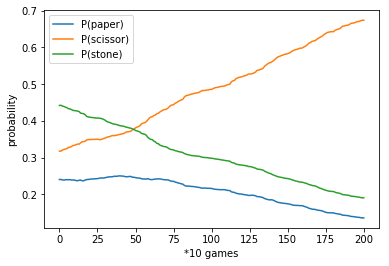

In [5]:
plt.plot(proba0, label="P(paper)")
plt.plot(proba1, label="P(scissor)")
plt.plot(proba2, label="P(stone)")
plt.xlabel('*10 games')
plt.ylabel('probability')
plt.legend(loc='best')
plt.show()

### The probability of choosing scissor increases

____
### Now, if the opponent changes the strategy, plays scissor with proba 1/2 and stone with proba 1/2

In [8]:
state = [[0,1]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
proba0 = [p[0]]
proba1 = [p[1]]
proba2 = [p[2]]
for ep in range(2000):
    ran = np.random.uniform(0,1,1)
    if ran[0] > 0.5:
        oppo = 1
    else:
        oppo = 2
    action = agent.choose_action(state)
    if oppo==1:
        if action==0:
            reward = -1
        elif action==1:
            reward = 0
        else:
            reward = 1
    else:
        if action==0:
            reward = 1
        elif action==1:
            reward = -1
        else:
            reward = 0
    agent.remember(state, [action], reward)
    agent.process_memory()
    if (ep+1) % 5 == 0:
        agent.replay()
    if (ep+1) % 10 == 0:
        p = agent.sess.run(agent.pi_probs, {agent.tfs: state})[0]
        proba0 += [p[0]]
        proba1 += [p[1]]
        proba2 += [p[2]]

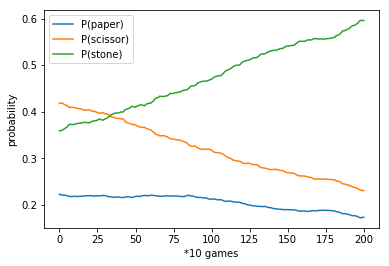

In [9]:
plt.plot(proba0, label="P(paper)")
plt.plot(proba1, label="P(scissor)")
plt.plot(proba2, label="P(stone)")
plt.xlabel('*10 games')
plt.ylabel('probability')
plt.legend(loc='best')
plt.show()

### Playing only stones is the best strategy

____
## Now, play against itself

In [214]:
agent = GameAgent(n_actions=3, n_features=2, learning_rate=1e-1)

In [228]:
player1_state = [[0,1]]
player2_state = [[1,0]]
p = agent.sess.run(agent.pi_probs, {agent.tfs: player1_state})[0]
p_ = agent.sess.run(agent.pi_probs, {agent.tfs: player2_state})[0]
player1_proba_paper = [p[0]]
player1_proba_scissors = [p[1]]
player1_proba_stone = [p[2]]
player2_proba_paper = [p_[0]]
player2_proba_scissors = [p_[1]]
player2_proba_stone = [p_[2]]
losses = []
eps = 1000

for ep in range(eps):
    agent.remember(player1_state, player2_state, 0, 0, 0)
    agent.remember(player1_state, player2_state, 0, 1, -1)
    agent.remember(player1_state, player2_state, 0, 2, 1)
    agent.remember(player1_state, player2_state, 1, 0, 1)
    agent.remember(player1_state, player2_state, 1, 1, 0)
    agent.remember(player1_state, player2_state, 1, 2, -1)
    agent.remember(player1_state, player2_state, 2, 0, -1)
    agent.remember(player1_state, player2_state, 2, 1, 1)
    agent.remember(player1_state, player2_state, 2, 2, 0)
    agent.process_memory()
    agent.replay(5)
    
    agent.remember(player2_state, player1_state, 0, 0, 0)
    agent.remember(player2_state, player1_state, 0, 1, -1)
    agent.remember(player2_state, player1_state, 0, 2, 1)
    agent.remember(player2_state, player1_state, 1, 0, 1)
    agent.remember(player2_state, player1_state, 1, 1, 0)
    agent.remember(player2_state, player1_state, 1, 1, -1)
    agent.remember(player2_state, player1_state, 2, 0, -1)
    agent.remember(player2_state, player1_state, 2, 1, 1)
    agent.remember(player2_state, player1_state, 2, 2, 0)
    agent.process_memory()
    agent.replay(2)
    
    p = agent.sess.run(agent.pi_probs, {agent.tfs: player1_state})[0]
    p_ = agent.sess.run(agent.pi_probs, {agent.tfs: player2_state})[0]
    oppo_pi_probs = agent.sess.run(agent.pi_probs, {agent.tfs: player2_state})
    losses += [-agent.sess.run(agent.loss, {agent.tfs: player1_state, agent.oppo_pi_probs: oppo_pi_probs, 
                        agent.tfa: [0,0,0,1,1,1,2,2,2], agent.tfa_oppo:[0,1,2,0,1,2,0,1,2], 
                        agent.tfdc_r: [0,-1,1,1,0,-1,-1,1,0]})]

    p = agent.sess.run(agent.pi_probs, {agent.tfs: player1_state})[0]
    p_ = agent.sess.run(agent.pi_probs, {agent.tfs: player2_state})[0]
    player1_proba_paper += [p[0]]
    player1_proba_scissors += [p[1]]
    player1_proba_stone += [p[2]]
    player2_proba_paper += [p_[0]]
    player2_proba_scissors += [p_[1]]
    player2_proba_stone += [p_[2]]

In [236]:
print('optimal strategy :')
print('P1(paper) =', np.mean(player1_proba_paper), 'P1(scissors) =', np.mean(player1_proba_scissors), 'P1(stone) =', np.mean(player1_proba_stone))
print('P2(paper) =', np.mean(player2_proba_paper), 'P2(scissors) =', np.mean(player2_proba_scissors), 'P2(stone) =', np.mean(player2_proba_stone))

optimal strategy :
P1(paper) = 0.324495 P1(scissors) = 0.331359 P1(stone) = 0.344146
P2(paper) = 0.332891 P2(scissors) = 0.337402 P2(stone) = 0.329707


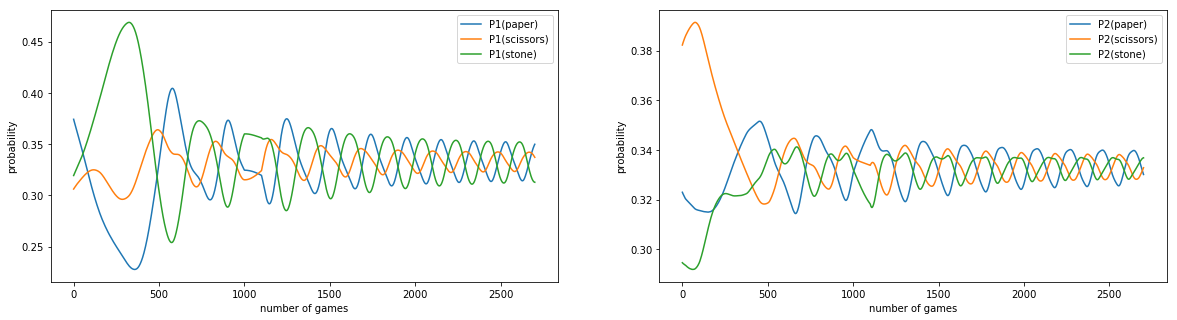

In [232]:
plt.subplots(figsize=(20,5))

plt.subplot(121)
plt.plot(player1_proba_paper, label="P1(paper)")
plt.plot(player1_proba_scissors, label="P1(scissors)")
plt.plot(player1_proba_stone, label="P1(stone)")
plt.xlabel('number of games')
plt.ylabel('probability')
plt.legend(loc='best')

plt.subplot(122)
plt.plot(player2_proba_paper, label="P2(paper)")
plt.plot(player2_proba_scissors, label="P2(scissors)")
plt.plot(player2_proba_stone, label="P2(stone)")
plt.xlabel('number of games')
plt.ylabel('probability')
plt.legend(loc='best')

plt.show()

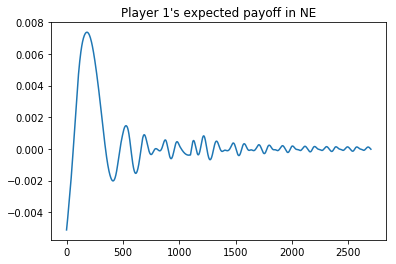

expected reward = 1.20571e-05


In [234]:
plt.title("Player 1's expected payoff in NE")
plt.plot(losses)
plt.show()
print('expected reward =',np.mean(losses[-100:]))

# The strategies converge to the mixed strategy NE!!

In [235]:
agent.saver.save(agent.sess, "model/pss_self_play3000.ckpt");

INFO:tensorflow:model/pss_self_play3000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
